<a href="https://colab.research.google.com/github/Kenz2000/Deep-Learning-project/blob/main/DeepLearningProject_MNIST_V2(last_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of MNIST data with only 100 labels.

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix,classification_report
from keras.datasets import mnist
from keras import backend as K
from collections import Counter
from keras.backend import clear_session
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten,Conv2D, MaxPooling2D
from keras.layers import Input, Flatten, Dense, ReLU, Activation, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D, Reshape
from keras.models import Model,Sequential
from keras.backend import clear_session
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam

## Loading the Dataset
MNIST comprises 60,000 grayscale images of size 28x28 representing the ten digits, and it also includes a test set containing 10,000 images.

In [ ]:
(X_train_Original, Y_train_Original), (X_test_Original, Y_test_Original) = mnist.load_data()
# Counting the number of every class
EachClassSize = Counter(Y_train_Original.reshape(-1))

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
clear_session()

We train our modelson one hundred examples labèls (10 of each) that are drawn randomly.

In [ ]:
# Taking  100 Data with labels
nber = 100 # number of labeled data
labels = [key for (key,value) in EachClassSize.items()] # take only the key of the dictionary object
idx100 = []
for i in range(len(labels)):
  idx = labels[i]==Y_train_Original
  index = np.arange(0,len(Y_train_Original))[idx]
  for j in range(10):
    idx100.append(index[j])


y_train100 = Y_train_Original[idx100]
x_train100 = X_train_Original[idx100]
x_train59900 = np.delete(X_train_Original,idx100,axis=0)

In [ ]:
EachClassSize_test_100 = Counter(y_train100.reshape(-1))

# Part 1 - Self supervised Learning

Self-supervised learning involves the following steps:

1. Utilizing unlabeled data.
2. Selecting a pretext task for classification.
3. Training the RotNet to learn the chosen pretext task.

In our article, the pretext task involves recognizing the geometric transformations applied to an input image given to the RotNet. The geometric transformations considered in the paper include image rotations by multiples degrees, specifically, 0, 90, 180, and 270 degrees.

As a result, the pseudo labels used will correspond to the rotations, such as 0 for "0°", 1 for "90°", 2 for "180°", and 3 for "270°".


## The rotation operator

The rotation operator, denoted as Rot(X;d), is defined as the operator that rotates the image X by an angle of d degrees.

In the context of the article, implementing image rotations of 90, 180, and 270 degrees (where 0 degrees corresponds to the original image) is achieved through the use of flip and transpose operations. To clarify:

- For a 90-degree rotation, the image is first transposed and then vertically flipped (upside-down flip).
- A 180-degree rotation involves first vertically flipping the image and then horizontally flipping it (left-right flip).
- Lastly, a 270-degree rotation is achieved by initially vertically flipping the image and then transposing it.

In [ ]:
def Rot(X, d):
  if d == 0: # 0 degrees rotation
      return X
  elif d == 90: # 90 degrees rotation
      return np.flipud(np.transpose(X))
  elif d == 180: # 180 degrees rotation
      return np.fliplr(np.flipud(X))
  elif d == 270: # 270 degrees rotation / or -90
      return np.transpose(np.flipud(X))
  else:
      raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


## Applying of the operator in the whole dataset
We perform the specified rotation operation on each image in the train and test datasets, excluding the 100 labeled images, and assign a label to the image indicating the type of rotation defined earlier.

The rotation operation on training data.


In [ ]:
n = x_train59900.shape[0]
RotX = np.zeros([4*n,28,28])# data obtained by rotation
Roty = np.zeros(4*n)# our pseudo labels
i=0
j=0
while i < 4*n:
  if j < n:
    RotX[i] = Rot(x_train59900[j],  0)
    RotX[i+1] = Rot(x_train59900[j],  90)
    RotX[i+2] = Rot(x_train59900[j],  180)
    RotX[i+3] = Rot(x_train59900[j],  270)
    Roty[i:i+4] = np.array([0,1,2,3])
    j = j + 1
  i = i + 4

The rotation operation on test data.

In [ ]:
n_test = X_test_Original.shape[0]
RotX_test = np.zeros([4*n_test,28,28])# data obtained by rotation
Roty_test = np.zeros(4*n_test)# our pseudo labels
i=0
j = 0
while i < 4*n_test:
  if j < n:
    RotX_test[i] = Rot(X_test_Original[j],  0)
    RotX_test[i+1] = Rot(X_test_Original[j],  90)
    RotX_test[i+2] = Rot(X_test_Original[j],  180)
    RotX_test[i+3] = Rot(X_test_Original[j],  270)
    Roty_test[i:i+4] = np.array([0,1,2,3])
    j = j + 1
  i = i+ 4

**The function that displays the result of the rotation operation**

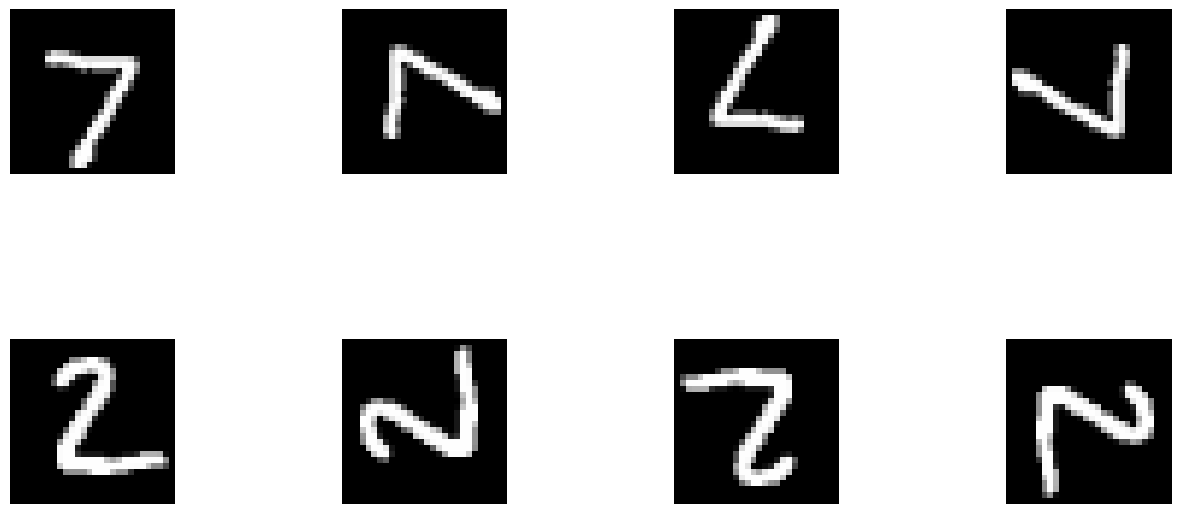

In [ ]:


def plot(samples):
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=1, hspace=1)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return

plot(RotX_test[0:8])


Display the result of the rotation applied to the train data.

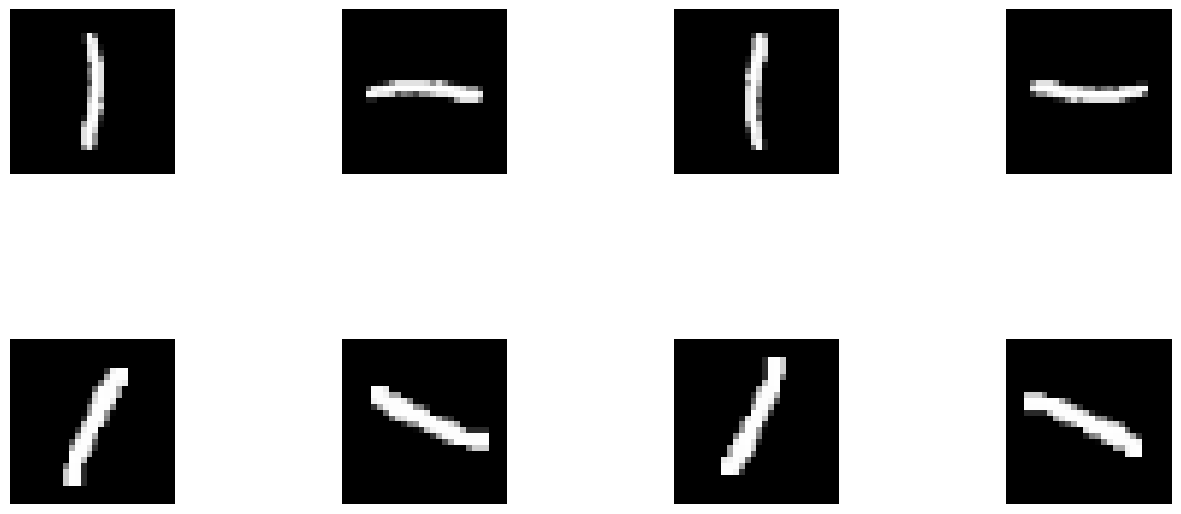

In [ ]:
plot(RotX[0:8])

Display the result of the rotation applied to the test data.

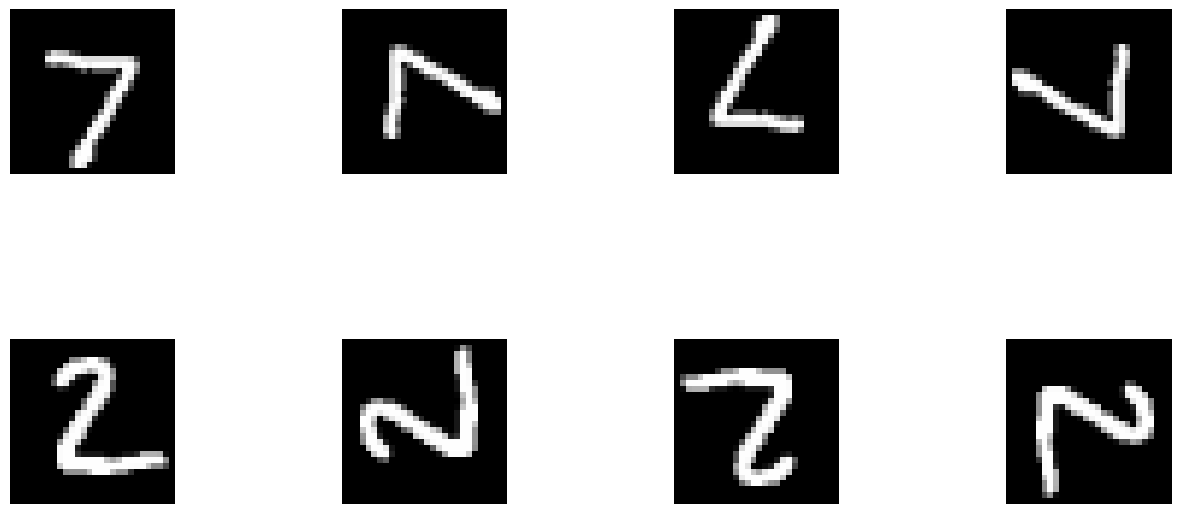

In [ ]:
plot(RotX_test[0:8])

## Data Preprocessing
In order to avoid overfitting, we have to apply some transformations

Splitting the transformed dataset Rot X into two sets: training and validation.

In [ ]:
# Splitting data

RotX_train, RotX_val, Roty_train, Roty_val = train_test_split(
                                 RotX, Roty,
                                 test_size = 0.2, random_state=12,
                                 shuffle = True, stratify = Roty)

For each degree of rotation(0,90,180,270), we generated 47,920 transformed images.

In [ ]:
Counter(list(Roty_train.reshape(-1)))

Counter({1.0: 47920, 2.0: 47920, 0.0: 47920, 3.0: 47920})

#### Convert class vectors to binary class matrices. (one-hot encoding)

In [ ]:
num_classes = np.int64(Roty.max()) +1

Normalize the data (images) as the model expects images of type float32.

In [ ]:
RotX_train = RotX_train.astype('float32')
RotX_train /= 255
RotX_train = RotX_train.reshape(-1, 28,28,1)

RotX_test = RotX_test.astype('float32')
RotX_test /= 255
RotX_test = RotX_test.reshape(-1, 28,28,1)

RotX_val = RotX_val.astype('float32')
RotX_val /= 255
RotX_val = RotX_val.reshape(-1, 28,28,1)

## Transform y in *categorial*

Transform y into categorical data for all three sets (train, validation, and test).

In [ ]:
Roty_train_before = Roty_train
Roty_test_before = Roty_test
Roty_val_before = Roty_val

In [ ]:
Roty = to_categorical(Roty, num_classes)
Roty_train = to_categorical(Roty_train, num_classes)
Roty_val = to_categorical(Roty_val, num_classes)
Roty_test = to_categorical(Roty_test, num_classes)

## Building the CNN
Now, we will build the CNN model for training to recognize the rotations applied to the images; it is referred to as RotNet here.

In [ ]:
clear_session()

## Modèle de base: **RotNet**

#Architecture
The "RotNet" model is composed of three blocks of Convolutional Neural Networks (CNN), and within each block, there are three Conv2D layers.

In [ ]:

RotNet = Sequential()

# Convolution

#Block 1

RotNet.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1),input_shape=(28, 28,1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 160, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 96, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(MaxPooling2D(pool_size = 3, padding='same', strides=(2,2)))


# Block 2

RotNet.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(AveragePooling2D(pool_size = 3, padding='same', strides=(2,2)))


# Block 3

RotNet.add(Conv2D(filters = 192, kernel_size= 3, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))



RotNet.add(GlobalAveragePooling2D())


RotNet.add(Dense(num_classes))
RotNet.add(Activation('softmax'))

Show the architecture of the RotNet model.

In [ ]:
RotNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 192)       4800      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 192)       768       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 160)       30720     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 160)       640       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 28, 28, 160)       0

## Training the RotNet model built in the precedent section

Define the optimizer

In [ ]:
opt = SGD(learning_rate=0.1, momentum=0.9,  nesterov=True)

Compile RotNetModel with the optimizer we defined, the loss function (categorical_crossentropy), and the metric (accuracy).

In [ ]:
#Define the optimizer, the loss function and the metrics
RotNet.compile(loss='categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

We will train the RotNet model on the training data and validate it on the validation data.

In [ ]:
# Démarrage de l'entrainement du réseau
hist = RotNet.fit(RotX_train, Roty_train,
            batch_size=128,
            epochs=20,
            shuffle=True,                       # verbosité
            verbose = 1,
            validation_data=(RotX_val, Roty_val))   # données de validation (X(données) et y(labels))

Epoch 1/20
1498/1498 [==============================] - 85s 49ms/step - loss: 0.0652 - accuracy: 0.9766 - val_loss: 0.1041 - val_accuracy: 0.9648
Epoch 2/20
1498/1498 [==============================] - 72s 48ms/step - loss: 0.0284 - accuracy: 0.9898 - val_loss: 0.0618 - val_accuracy: 0.9777
Epoch 3/20
1498/1498 [==============================] - 72s 48ms/step - loss: 0.0223 - accuracy: 0.9921 - val_loss: 0.0218 - val_accuracy: 0.9929
Epoch 4/20
1498/1498 [==============================] - 71s 48ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0321 - val_accuracy: 0.9878
Epoch 5/20
1498/1498 [==============================] - 72s 48ms/step - loss: 0.0167 - accuracy: 0.9940 - val_loss: 0.0193 - val_accuracy: 0.9928
Epoch 6/20
1498/1498 [==============================] - 72s 48ms/step - loss: 0.0148 - accuracy: 0.9948 - val_loss: 0.0336 - val_accuracy: 0.9891
Epoch 7/20
1498/1498 [==============================] - 72s 48ms/step - loss: 0.0128 - accuracy: 0.9955 - val_loss: 0.0236 -

**Plot the accuracy for the training and validation sets.**

We plot the learning curve of the network in order to see the diffrence of evolution of the accuracy between the training set and the validation test ,we can see that the accuracy between the the two sets converge to almost 100% after 18 epochs .

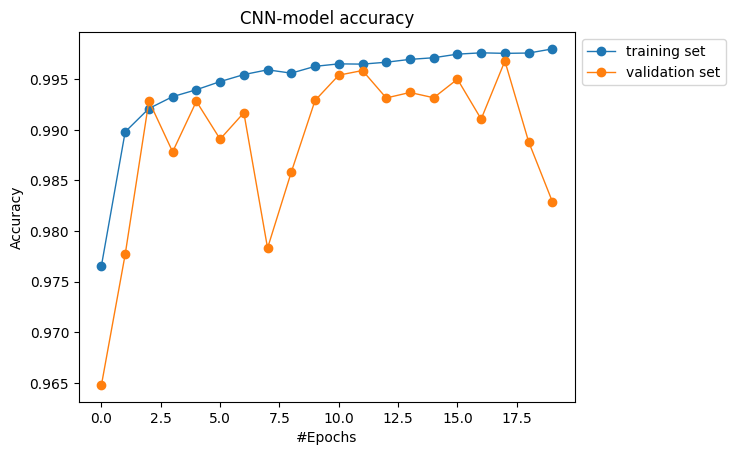

In [ ]:
plt.plot(hist.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

**Plot the loss function for the training and validation sets**

We plot the curve of the loss function of the trained RotNet model.We can constate that the loss function converge after 18 epochs for the two sets :training set and validation set.It is a good thing because we can say that our model has not the overfitting

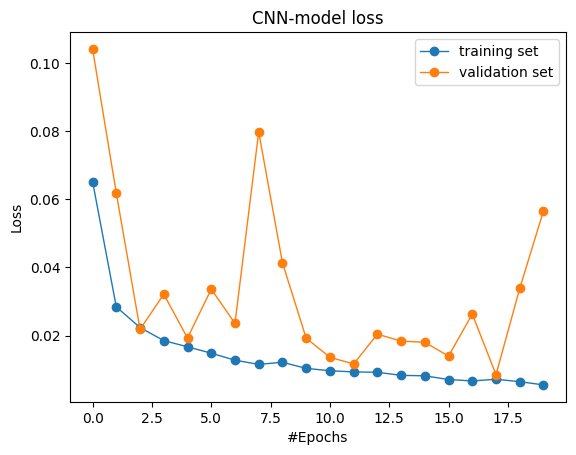

In [ ]:
plt.plot(hist.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

In [ ]:
LABELS = {
    0 : "0°",
    1 : "90°",
    2 : "180°",
    3 : "270°",
}
list(LABELS.items())

[(0, '0°'), (1, '90°'), (2, '180°'), (3, '270°')]

# Test on the validation data

Apply the model to RotX_val to obtain the predicted Y.

In [ ]:
y_pred = RotNet.predict(RotX_val)
y_pred = np.argmax(y_pred, axis=1)

1498/1498 [==============================] - 7s 4ms/step


Reshape the correct Y according to the shape of the predicted Y.

In [ ]:
y_true = Roty_val_before.reshape(y_pred.shape)

Compute the accuracy score by comparing predicted y with the correct y.

In [ ]:
accuracy_score(y_true=y_true,y_pred=y_pred)

0.9829090150250417

**visualize the predictions of the rotations Function**

In [ ]:
def visualize_prediction_RotNet(X,Y):
    # Sample test data
  ix = np.random.randint(0, 10000, size=36)
  ex_im = X[ix]
  ex_lb = Y[ix]

  # Predict
  out = RotNet.predict(ex_im) #RotNet
  classes = np.argmax(out, axis=1)  # softmax output -> class

  # Plot
  fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharey=True, sharex=True);
  fig.suptitle(r'$\rightarrow$ CNN predicted (actual) $\leftarrow$')

  k = 0
  for i in range(6):
      for j in range(6):
          # Switch Axes
          ax = axes[i, j]

          # Show image
          ax.imshow(ex_im[k].reshape(28, 28), cmap='Greys_r');

          # Determine labels
          actual_lab = LABELS[np.argmax(ex_lb[k])]
          pred_lab = LABELS[classes[k]]

          # Format title
          title = "{} ({})".format(pred_lab, actual_lab)
          title_color = 'black'

          # Mark image if wrong prediction
          if actual_lab != pred_lab:
              ax.plot(np.array([0, 32]), np.array([0, 32]), 'r-')
              ax.plot(np.array([0, 32]), np.array([32, 0]), 'r-')
              title_color = 'red'

          # Set title
          ax.set_title(title, color=title_color);

          # Set limits
          ax.set_xlim(32, 0)
          ax.set_ylim(32, 0)

          k += 1

We visualize the predictions of the rotations on the validation data. If it predicts incorrectly, we place a red cross on the predicted image.

2/2 [==============================] - 0s 193ms/step


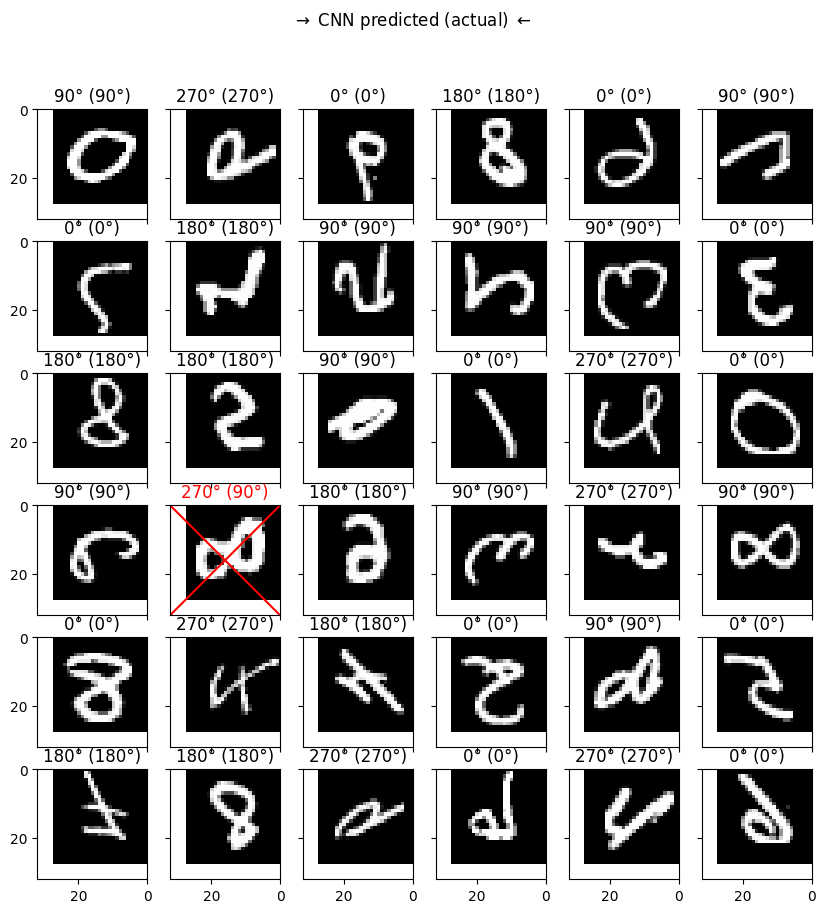

In [ ]:
visualize_prediction_RotNet(RotX_val,Roty_val)

# Test on the test data



Apply the model to RotX_test to obtain the predicted Y.

In [ ]:
y_pred = RotNet.predict(RotX_test)
y_pred = np.argmax(y_pred, axis=1)

1250/1250 [==============================] - 5s 4ms/step


Reshape the correct Y according to the shape of the predicted Y.

In [ ]:
y_true = Roty_test_before.reshape(y_pred.shape)

Compute the accuracy score by comparing predicted y with the correct y.

In [ ]:
accuracy_score(y_true=y_true,y_pred=y_pred)

0.982075

We visualize the predictions of the rotations on the validation data. If it predicts incorrectly, we place a red cross on the predicted image.

2/2 [==============================] - 0s 5ms/step


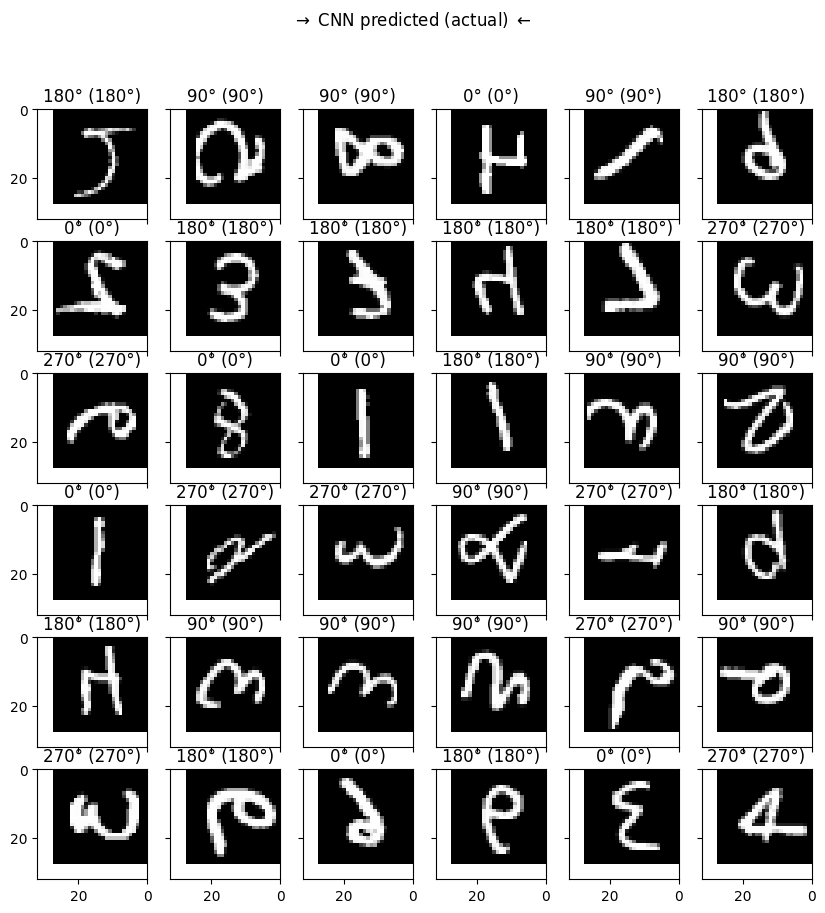

In [ ]:
visualize_prediction_RotNet(RotX_test,Roty_test)

By comparing the predicted classes with the actual classes, we observe that for the test set, the CNN correctly classified all the images.

In [ ]:
scores = RotNet.evaluate(RotX_test, Roty_test, batch_size=128)

313/313 [==============================] - 4s 14ms/step - loss: 0.0591 - accuracy: 0.9821


Compute and plot the curve of accuracy and loss on test set

In [ ]:
accuracy=[]
loss=[]
j=0
for i in range(1000,len(Roty_test)+1000,1000):
  scores = RotNet.evaluate(RotX_test[j:i], Roty_test[j:i], batch_size=128)
  loss.append(scores[0])
  accuracy.append(scores[1])
  j=i

8/8 [==============================] - 0s 13ms/step - loss: 0.0415 - accuracy: 0.9870


Plot the accuracy curve on test data

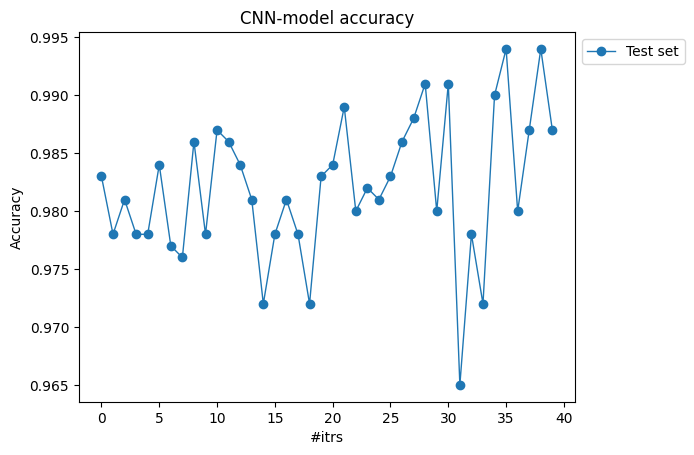

In [ ]:
plt.plot(accuracy, label='Test set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#itrs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

Plot the Lss function curve on test data

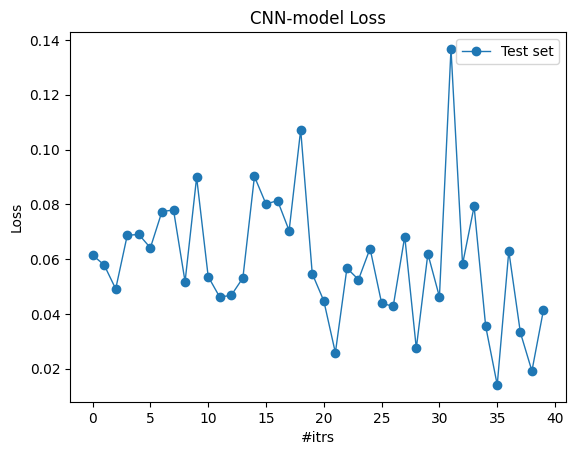

In [ ]:
plt.plot(loss, label='Test set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model Loss")
plt.xlabel('#itrs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

# Freezing certain part from RotNet model

Here, a copy of the created model, named RotNet, is made.

In [ ]:
model_frozen = RotNet

In [ ]:
model_frozen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 192)       4800      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 192)       768       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 160)       30720     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 160)       640       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 28, 28, 160)       0

# Layers freezing

-The first two blocks are frozen.

-The weights remain editable from the last (third) block.

-The first 20 layers correspond to the first two blocks of our base model.
 (for each bloc , 3*(Con2D layer,Batch normalization layer ,Activation layers)) +MaxPooling layer ) Each bloc contains 10 layers

In [ ]:
for layer in model_frozen.layers[:20]:
    layer.trainable=False

for layer in model_frozen.layers[20:]:
    layer.trainable=True

Retrieve class numbers from the training labels (y_train).

In [ ]:
num_classes2 = np.int64(y_train100.max()) +1

The architecture of the frozen model

In [ ]:
model_frozen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 192)       4800      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 192)       768       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 160)       30720     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 160)       640       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 28, 28, 160)       0

We select the output from the fourth-to-last layer, starting from the last block of RotNet. This layer corresponds to the final layer before the classification layers, and its outputs represent the image features.

Subsequently, Global Average Pooling is applied to extract the weights from the frozen layers.

Finally, a Dense layer with 10 units and a softmax activation function is added for predicting the ten classes (0, 1, ..., 9).


In [ ]:
X= model_frozen.layers[-4].output
InputMod = tf.keras.Input(shape=(28, 28, 1))
globalAv = GlobalAveragePooling2D()(X)
predictions = Dense(num_classes2, activation="softmax")(globalAv)
model_final = tf.keras.Model(model_frozen.input,predictions)

In [ ]:

X_test, X_val, Y_test, Y_val = train_test_split(
                                 X_test_Original, Y_test_Original,
                                 test_size = 0.01, random_state=12,
                                 shuffle = True)

Optimizer of the final model

In [ ]:

opt1= SGD(learning_rate=0.1, momentum=0.9,  nesterov=True)

#

Compile Final model with the optimizer we defined, the loss function (categorical_crossentropy), and the metric (accuracy).

In [ ]:
model_final.compile(loss='categorical_crossentropy', optimizer=opt1, metrics=["accuracy"])

We normalize the training data into float32 and create a copy of the original y data

In [ ]:
X_val2 = X_val.astype('float32')
X_val2 /= 255
X_val2 = X_val2.reshape(-1, 28,28,1)
y_val_before = Y_val

In [ ]:
x_train100_2 = x_train100.astype('float32')
x_train100_2 /= 255
x_train100_2 = x_train100_2.reshape(-1, 28,28,1)
y_train100_before = y_train100

We convert y_train100 into categorical data

In [ ]:
Y_val2 = to_categorical(Y_val, num_classes2)
Y_val2.shape

(100, 10)

In [ ]:
y_train100_2 = to_categorical(y_train100, num_classes2)
y_train100_2.shape

(100, 10)

We train the ultimate model using the 100 labeled data points

In [ ]:
hist2 = model_final.fit(x_train100_2, y_train100_2,
            batch_size = 10,
            epochs=30,
            shuffle=True,                       # verbosité
            verbose = 1,
            validation_data=(X_val2, Y_val2)
            )

Epoch 1/30
10/10 [==============================] - 2s 40ms/step - loss: 2.8704 - accuracy: 0.1100 - val_loss: 2.6618 - val_accuracy: 0.3000
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 2.9864 - accuracy: 0.3300 - val_loss: 1.9128 - val_accuracy: 0.4300
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 1.4180 - accuracy: 0.5600 - val_loss: 2.2567 - val_accuracy: 0.4700
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 1.3258 - accuracy: 0.5900 - val_loss: 1.7256 - val_accuracy: 0.4900
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 0.6135 - accuracy: 0.8100 - val_loss: 1.1094 - val_accuracy: 0.6500
Epoch 6/30
10/10 [==============================] - 0s 14ms/step - loss: 0.4309 - accuracy: 0.8700 - val_loss: 1.4733 - val_accuracy: 0.4800
Epoch 7/30
10/10 [==============================] - 0s 10ms/step - loss: 0.3014 - accuracy: 0.9000 - val_loss: 4.1221 - val_accuracy: 0.2300
Epoch 8/30
10

**Plot the learning curves and loss function for the training set**

Plot the accuracy

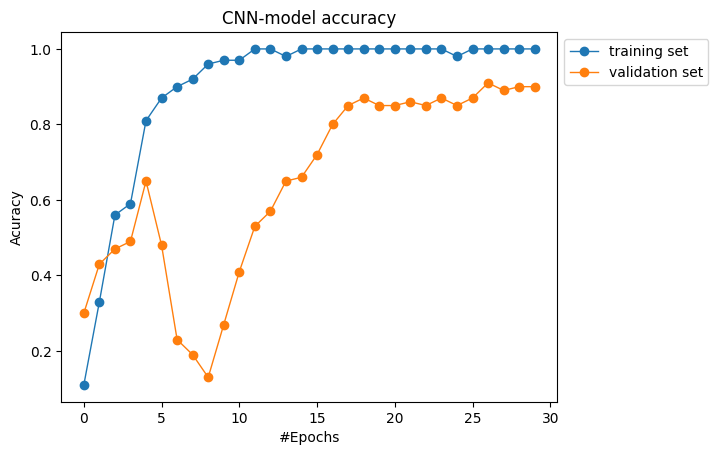

In [ ]:
plt.plot(hist2.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist2.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

Plot the loss function

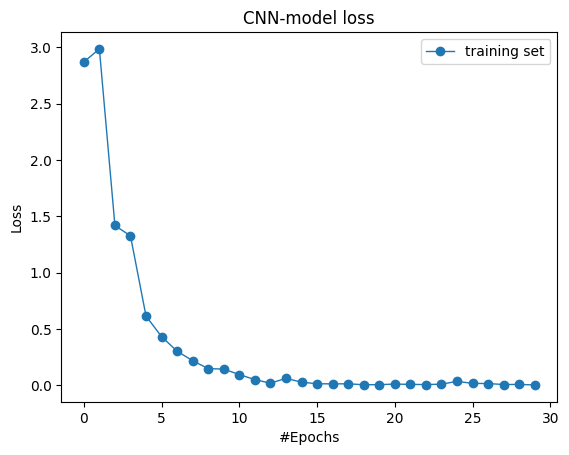

In [ ]:
plt.plot(hist2.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

Apply the model final to x_train100_2 to obtain the predicted Y.

In [ ]:
y_pred = model_final.predict(x_train100_2)
y_pred = np.argmax(y_pred, axis=1)

4/4 [==============================] - 0s 6ms/step


In [ ]:
LABELS2 = {
    0 : "0",
    1 : "1",
    2 : "2",
    3 : "3",
    4 : "4",
    5 : "5",
    6 : "6",
    7 : "7",
    8 : "8",
    9 : "9"
}

# Test the final model with train100 data (labelled data)

In [ ]:
y_true = y_train100_before.reshape(y_pred.shape)

### Accuracy

In [ ]:

accuracy_score(y_true=y_true,y_pred=y_pred)

1.0

# Test with the test set of the unlabbeled data

In [ ]:
X_test = X_test_Original.astype('float32')
X_test /= 255
X_test = X_test.reshape(-1, 28,28,1)

## Test data accuracy.

In [ ]:
y_pred3 = model_final.predict(X_test)
y_pred3 = np.argmax(y_pred3, axis=1)

313/313 [==============================] - 2s 6ms/step


In [ ]:
y_true3 = Y_test_Original.reshape(y_pred3.shape)

In [ ]:
accuracy_score(y_true=y_true3,y_pred=y_pred3)

0.8684

Convert the test labels to categorical.

In [ ]:
y_test = to_categorical(Y_test_Original, num_classes2)

Accuracy for the test data.

In [ ]:
scores = model_final.evaluate(X_test, y_test, batch_size=128)

79/79 [==============================] - 2s 16ms/step - loss: 0.5264 - accuracy: 0.8684


Accuracy for the test data.



In [ ]:
accuracy=[]
loss=[]
j=0
for i in range(1000,len(y_test)+1000,1000):
  scores = model_final.evaluate(X_test[j:i], y_test[j:i], batch_size=128)
  loss.append(scores[0])
  accuracy.append(scores[1])
  j=i

8/8 [==============================] - 0s 15ms/step - loss: 0.3739 - accuracy: 0.8930


PLot the curve of accuracy

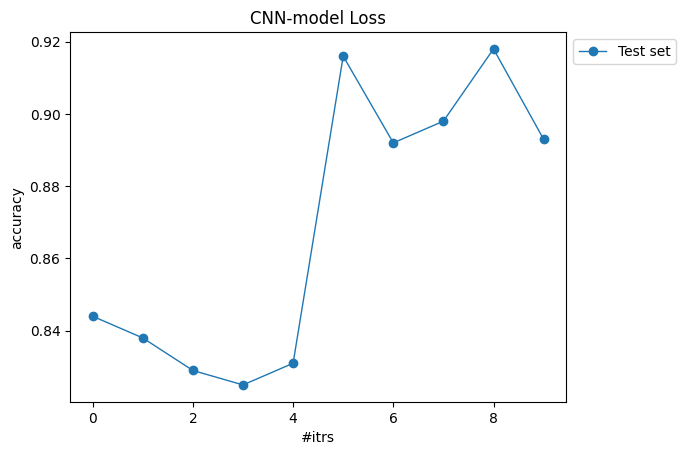

In [ ]:
plt.plot(accuracy, label='Test set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model Loss")
plt.xlabel('#itrs')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

In analyzing the accuracy progression of the test set, we notice a convergence to almost 89%, indicating that the model is performing well.

Plot the curve of LOSS

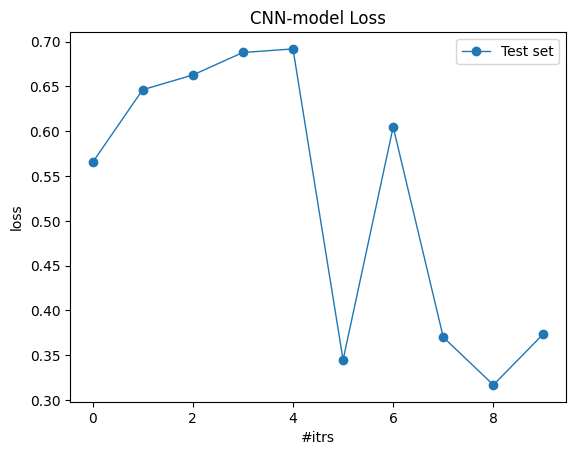

In [ ]:
plt.plot(loss, label='Test set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model Loss")
plt.xlabel('#itrs')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=( 1., 1.))

Examining the loss curve with respect to iterations, we observe that the loss function is 0.37.

In [ ]:
def show_data_label_prediction(X, y_true, model, num_examples=8):
    # Make predictions on the data
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Randomly select examples
    indices = np.random.choice(len(X), num_examples)

    # Plot the examples
    plt.figure(figsize=(12, 6))
    for i, index in enumerate(indices, 1):
        plt.subplot(1, num_examples, i)
        plt.imshow(X[index].reshape(28, 28), cmap='gray')
        plt.title(f'True: {np.argmax(y_true[index])}\nPred: {y_pred_classes[index]}')
        plt.axis('off')

    plt.show()

**Results obtained after applying the baseline model to the test data**

The following test examples illustrate its performance and robustness.

313/313 [==============================] - 1s 4ms/step


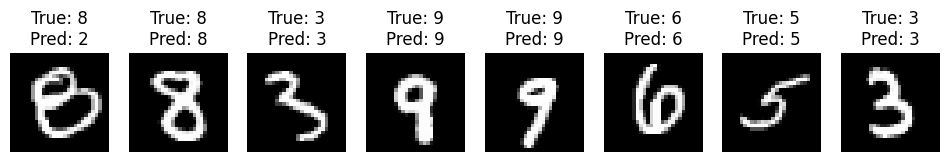

In [ ]:
show_data_label_prediction(X_test, y_test, model_final)

# Baseline model (supervised model)

In this scenario, we are constructing a model that shares the same architecture as our final model, specifically the classification component. Nevertheless, we will not employ any geometric transformations in an effort to extract image features. The objective is to contrast this model with our semi-supervised model.

In [ ]:
clear_session()

In [ ]:

baseline = Sequential()

# Convolution

#Block 1

baseline.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1),input_shape=(28, 28,1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 160, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 96, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(MaxPooling2D(pool_size = 3, padding='same', strides=(2,2)))

# Block 2

baseline.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(AveragePooling2D(pool_size = 3, padding='same', strides=(2,2)))

# Block 3

baseline.add(Conv2D(filters = 192, kernel_size= 3, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(GlobalAveragePooling2D())


baseline.add(Dense(num_classes2))
baseline.add(Activation('softmax'))

Show the architecture of the Baseline model.

In [ ]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 192)       4800      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 192)       768       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 160)       30720     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 160)       640       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 28, 28, 160)       0

## Training the Baseline model

Define the optimizer

In [ ]:
opt2 = SGD(learning_rate=0.1, momentum=0.9,  nesterov=True)

Compile BaselineModel with the optimizer we defined, the loss function (categorical_crossentropy), and the metric (accuracy).

In [ ]:
baseline.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=["accuracy"])

Now, we will train the baseline model.

In [ ]:
hist3 = baseline.fit(x_train100_2, y_train100_2,
            batch_size=50,
            epochs=10,
            shuffle=True,                       # verbosité
            verbose = 1,
            )

Epoch 1/10
2/2 [==============================] - 3s 26ms/step - loss: 2.3776 - accuracy: 0.1200
Epoch 2/10
2/2 [==============================] - 0s 24ms/step - loss: 1.7297 - accuracy: 0.5700
Epoch 3/10
2/2 [==============================] - 0s 22ms/step - loss: 1.1881 - accuracy: 0.7800
Epoch 4/10
2/2 [==============================] - 0s 22ms/step - loss: 0.6984 - accuracy: 0.9400
Epoch 5/10
2/2 [==============================] - 0s 23ms/step - loss: 0.4507 - accuracy: 0.9400
Epoch 6/10
2/2 [==============================] - 0s 22ms/step - loss: 0.2230 - accuracy: 0.9900
Epoch 7/10
2/2 [==============================] - 0s 22ms/step - loss: 0.1072 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 23ms/step - loss: 0.0557 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 22ms/step - loss: 0.0413 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 22ms/step - loss: 0.0184 - accuracy: 1.0000


**Plot the learning curves and loss function for the training set**

Plot the accuracy

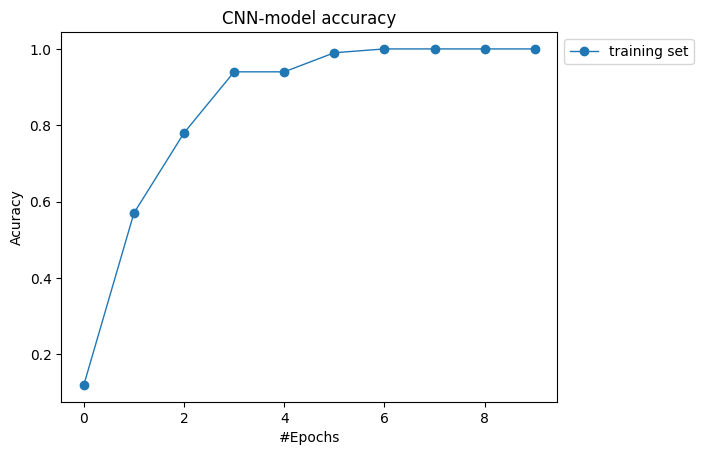

In [ ]:
plt.plot(hist3.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

Plot the Loss function

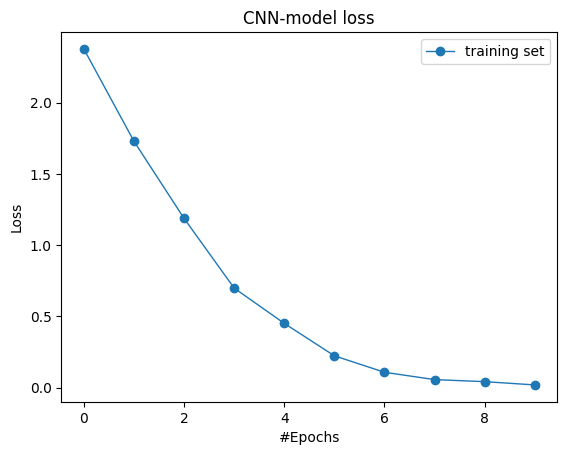

In [ ]:
plt.plot(hist3.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

**Test The model on the Test set**

Apply the model to Baseline to obtain the predicted Y.

In [ ]:
y_pred5 = baseline.predict(X_test)
y_pred5 = np.argmax(y_pred5, axis=1)

313/313 [==============================] - 1s 4ms/step


Reshape the correct Y according to the shape of the predicted Y.

In [ ]:
y_true5 = Y_test_Original.reshape(y_pred5.shape)

Compute the accuracy score by comparing predicted y with the correct y.

In [ ]:
accuracy_score(y_true=y_true5,y_pred=y_pred5)

0.174

Compute the scores (accuracy, loss) by comparing the predicted classes with the respective actual classes.

In [ ]:
scores = baseline.evaluate(X_test, y_test, batch_size=10)

1000/1000 [==============================] - 5s 5ms/step - loss: 2.2412 - accuracy: 0.1740


During the evaluation of the baseline model on the test data, we observed an accuracy rate of 0.17, indicating very poor performance and suggesting the presence of overfitting. Subsequent test results further support our findings.


Compute and plot Accuracy and Loss  for the test data.

In [ ]:
accuracy=[]
loss=[]
j=0
for i in range(1000,len(y_test)+1000,1000):
  scores = baseline.evaluate(X_test[j:i], y_test[j:i], batch_size=128)
  loss.append(scores[0])
  accuracy.append(scores[1])
  j=i

8/8 [==============================] - 0s 15ms/step - loss: 2.2353 - accuracy: 0.1910


Plot accuracy

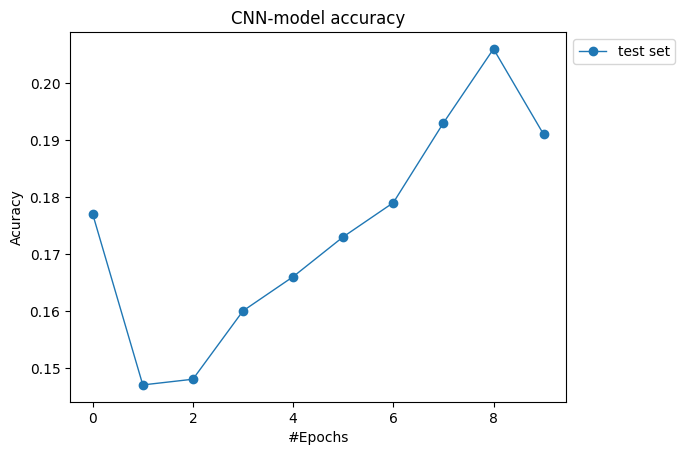

In [ ]:
plt.plot(accuracy, label='test set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

According to the curve, we see that the accuracy score obtained is 0.19, which is very low and indicates overfitting.

Plot loss

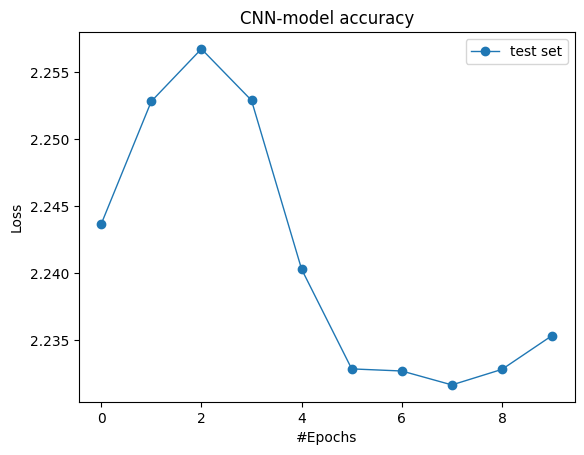

In [ ]:
plt.plot(loss, label='test set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

Examining the loss curve with respect to iterations, we observe that the loss function is 2.24.

**Results obtained after applying the baseline model to the test data**

313/313 [==============================] - 2s 7ms/step


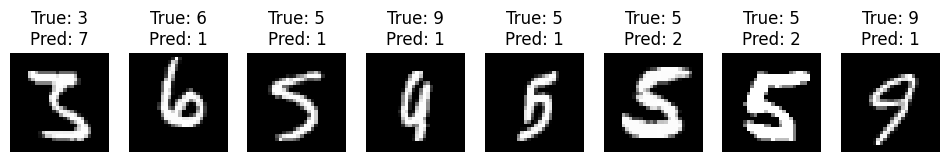

In [ ]:
show_data_label_prediction(X_test, y_test, baseline)